### 2.12. Анализ динамики удержания произвольных когорт

В предыдущем уроке вы проанализировали удержание с разбивкой по устройствам и построили отдельные графики для платящих и неплатящих игроков.

Разделение пользователей на платящих и неплатящих позволяет избежать многих, но далеко не всех проблем с читаемостью графиков. Например, по правому графику с кривыми удержания неплатящих пользователей магазина «Читать не вредно» сложно определить, пользователи каких устройств удерживаются хоть сколько-то лучше.

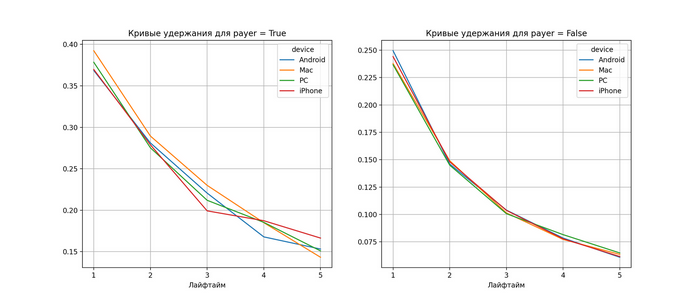

Избежать слияния линий позволит третий изученный вами способ визуализации — график истории изменений. На таком графике каждая линия соответствует определённому лайфтайму, а по горизонтальной оси отмечены даты привлечения пользователей. 

Однако построить его теперь непросто: после добавления параметра `dimensions` даты привлечения пользователей пропали из таблицы удержания.


In [1]:
import pandas as pd
import seaborn as sns

In [14]:
# загрузим датафреймы result_raw, profiles и sessions,
# получившиеся в предыдущем уроке, чтобы не повторять их вычисление
result_raw = pd.read_csv('/datasets/result_backup.csv')
profiles = pd.read_csv('/datasets/profiles_backup.csv')
sessions = pd.read_csv('/datasets/sessions_backup.csv')

In [15]:
# преобразование типов
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

In [16]:
result_raw['first_ts'] = pd.to_datetime(result_raw['first_ts'])
result_raw['month'] = pd.to_datetime(result_raw['month'])
result_raw['session_start'] = pd.to_datetime(result_raw['session_start'])

Ещё раз взгляните на код функции `get_retention()`.

In [17]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],  # параметр для группировки таблицы удержания
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

Чтобы получить графики и таблицу удержания выше, мы передали функции `get_retention()` такой набор аргументов:

- `profiles` — профили пользователей,
- `sessions` — журнал сессий,
- `datetime(2019, 5, 13).date()` — момент анализа,
- `6` — горизонт анализа,
- `dimensions=['device']` — столбец для группировки таблицы удержания.

In [18]:
from datetime import datetime, timedelta

# расчёт удержания с разбивкой по совершению покупок и устройствам
retention_raw, retention = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 6, dimensions=['device']
)

Чтобы вернуть в таблицу удержания даты привлечения пользователей, снова вызовем `get_retention()`, но на этот раз передадим параметру `dimensions` не только столбец `device` с названиями устройств, но и столбец `dt` с датами первого перехода на сайт. Разделение на платящих и неплатящих пользователей уже «зашито» в код функции.


In [19]:
retention_raw, retention = get_retention(
    profiles,
    sessions,
    datetime(2019, 5, 13).date(),
    6,
    dimensions=['device', 'dt'], 
)

# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

report

1         2         3         4         5
payer device  dt                                                          
False Android 2019-05-01  0.392990  0.278279  0.217207  0.169411  0.152416
              2019-05-02  0.404856  0.288058  0.220472  0.188976  0.147638
              2019-05-03  0.183611  0.089341  0.051756  0.034504  0.024646
              2019-05-04  0.168753  0.089134  0.048573  0.033050  0.020531
              2019-05-05  0.133827  0.044938  0.029136  0.015309  0.007901
...                            ...       ...       ...       ...       ...
True  iPhone  2019-05-04  0.319444  0.241319  0.126736  0.123264  0.085069
              2019-05-05  0.251773  0.127660  0.086879  0.070922  0.051418
              2019-05-06  0.361582  0.256121  0.169492  0.167608  0.148776
              2019-05-07  0.328671  0.289044  0.156177  0.193473  0.153846
              2019-05-08  0.394937  0.311392  0.250633  0.232911  0.207595

[64 rows x 5 columns]

Получаем таблицу удержания, сгруппированную по трём признакам:

- Совершение покупок. Столбец `payer`, значение `True` или `False`.
- Устройство, с которого пользователь просматривает сайт. Столбец `device`, значения `Android`, `Mac`, `PC` или `iPhone`.
- Дата привлечения пользователей. Столбец `dt` с датами от 1 до 8 мая 2019 года.

Используем эту таблицу, чтобы построить графики истории изменений — или динамики удержания — с разбивкой по устройствам и совершению покупок.


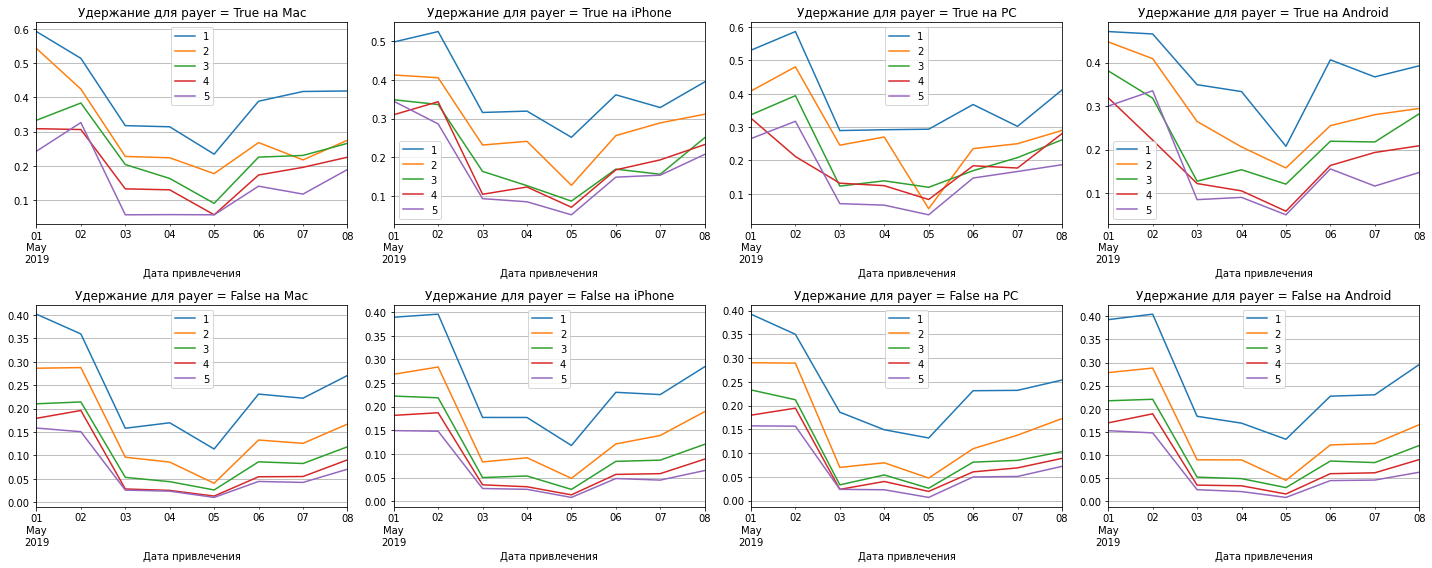

In [20]:
import matplotlib.pyplot as plt

# строим графики истории изменений

plt.figure(figsize=(20, 8))  # задаём размер сетки

# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

# определяем количество строк в таблице графиков
# платящим и неплатящим отведём по строке
num_rows = len(profiles['payer'].unique())

# определяем количество столбцов в таблице графиков
# по столбцу на каждое устройство, всего четыре
num_cols = len(profiles['device'].unique())

# перебираем пары «порядковый номер-элемент» из уникальных значений payer
# будет две пары: (0, True) и (1, False)
# обратите внимание, что номера не отражают смысл значений
for i, payer in enumerate(profiles['payer'].unique()):
    # перебираем пары «порядковый номер-элемент» из уникальных значений device
    # будет четыре пары: (0, 'Mac'), (1, 'iPhone'), (2, 'PC'), (3, 'Android')
    for j, device in enumerate(profiles['device'].unique()):
        (
            # фильтруем датафрейм по наличию покупок и устройству
            report.query('payer == @payer and device == @device')
            # устраняем payer и device из индексов,
            # чтобы не загромождать графики
            .droplevel(['payer', 'device'])
            # строим каждый график в своей ячейке
            .plot(
                grid=True,
                # в таблице графиков две строки и четыре столбца
                # i принимает значение 0 или 1, в зависимости от покупки
                # j — 0, 1, 2 или 3, в зависимости от устройства
                # график для неплатящих пользователей Mac окажется
                # в пятой ячейке: 1 * 4 + 0 + 1 = 5
                # а для платящих пользователей Android —
                # в четвёртой: 0 * 4 + 3 + 1 = 4
                ax=plt.subplot(num_rows, num_cols, i * num_cols + j + 1),
            )
        )
        # подпись оси X
        plt.xlabel('Дата привлечения')
        # названия графиков
        plt.title('Удержание для payer = {} на {}'.format(payer, device))

plt.tight_layout()
plt.show()

На верхней строке — графики удержания платящих пользователей, а на нижней — неплатящих. Каждый график отражает динамику удержания для определённого устройства. Например, первый график на верхней строке соответствует удержанию платящих пользователей, которые впервые зашли на сайт с устройства Mac, а третий график на нижней строке — неплатящих пользователей PC.

По горизонтальной оси на каждом графике отложены даты привлечения пользователей, по вертикальной — доля удержанных, а линии отражают изменения этой доли на каждый лайфтайм с течением времени, то есть для разных дат привлечения. Например, синяя линия на всех графиках показывает, как менялось удержание на второй день «жизни» пользователей, а зелёная — на четвёртый.

Кривые удержания для разных устройств показывают примерно одинаковую динамику: все они резко падают 3 мая, а 5 мая начинают восстановление. Это значит, что пользователи, привлечённые с 3 по 5 мая, удерживались намного хуже остальных. Например, удержание второго дня «жизни» для неплатящих пользователей PC, привлечённых в этот период, составляет около 15%, а для тех же пользователей, привлечённых с 6 по 8 мая, — около 25%. То есть с 6 по 8 мая интернет-магазин «Читать не вредно» привлекал более «качественных» пользователей, чем с 3 по 5 мая.

Интересно теперь сравнить эти выводы с тем, что «говорят» кривые удержания без дат привлечения. Построим их, запустив прежний код.


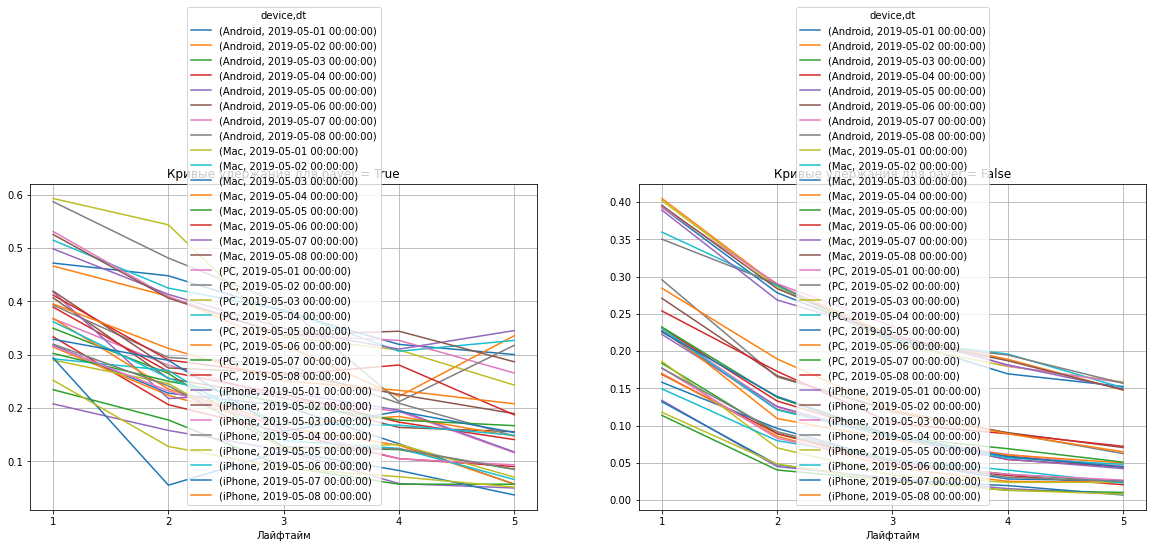

In [21]:
# строим кривые удержания
# запускаем тот же код

plt.figure(figsize=(20, 6))  # задаём размер сетки

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,  # добавляем сетку
        # отметки на оси X — названия колонок
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

Кажется, графики сломались.

Чтобы построить кривые удержания с разбивкой по совершению покупок и устройствам, параметру `dimensions` при вызове функции `get_retention()` нужно передать только столбец `device`. Перегруппировать текущую таблицу уже не выйдет: для группировки нужны сырые данные, а не готовые коэффициенты.

На практике аналитик почти всегда хочет видеть и кривые удержания, и графики истории изменений. Чтобы иметь доступ и к тому, и к другому виду графиков, можно вызвать `get_retention()` дважды — с разным набором столбцов в параметре `dimensions`.


In [22]:
# один вызов для построения кривых удержания
retention_raw, retention = get_retention(
    profiles,
    sessions,
    datetime(2019, 5, 13).date(),
    6,
    dimensions=['device'], 
)

# и другой — для построения графиков динамики удержания
retention_raw, retention_history = get_retention(
    profiles,
    sessions,
    datetime(2019, 5, 13).date(),
    6,
    dimensions=['device', 'dt'], 
)

Однако это не лучший вариант. 

Во-первых, мы дважды создаём один и тот же датафрейм с сырыми данными `retention_raw`. Это замедляет работу программы. 

Во-вторых, за одно исследование аналитик обычно рассчитывает удержание не один, а множество раз — с разбивкой когорт по совершенно разным признакам. Каждый раз вызывать одну и ту же функцию дважды неудобно.

Гораздо эффективнее за один вызов `get_retention()` получать сразу три таблицы:

- сырые данные,
- таблицу удержания,
- таблицу динамики удержания.

Таблица динамики удержания отличается от простой таблицы удержания группировкой по дополнительному признаку — дате привлечения пользователей. Добавим в тело функции `get_retention()` создание таблицы `result_in_time`, которая будет сгруппирована по всем признакам из `dimensions`, а также столбцу `dt`.


In [23]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],  # параметр для группировки таблицы удержания
    ignore_horizon=False,
):

    # --- получаем сырые данные и таблицу удержания ---

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(
        result_grouped['cohort_size'], axis=0
    ).drop(columns=['cohort_size'])

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]
    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # --- создаём таблицу динамики удержания ---

    # добавляем даты привлечения в параметр dimensions
    dimensions = ['dt'] + dimensions

    # рассчитываем удержание
    result_in_time = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_in_time = cohort_sizes.merge(
        result_in_time, on=dimensions, how='left'
    ).fillna(0)
    result_in_time = result_in_time.div(
        result_in_time['cohort_size'], axis=0
    ).drop(columns=['cohort_size'])

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_in_time = result_in_time[
        ['cohort_size'] + list(range(horizon_days))
    ]
    # восстанавливаем столбец с размерами когорт
    result_in_time['cohort_size'] = cohort_sizes

    # возвращаем сырые данные, таблицу удержания и таблицу динамики удержания
    return result_raw, result_grouped, result_in_time

Теперь `get_retention()` возвращает не только сырые данные и таблицу удержания, но и таблицу динамики удержания. Правда, код функции заметно «распух».

Расчёт удержания для `result_grouped` и `result_in_time` идентичен.

```python
# для таблицы удержания:

    # рассчитываем удержание 
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(
        result_grouped['cohort_size'], axis=0
    ).drop(columns=['cohort_size'])

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]
    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes
```

```python
# для таблицы динамики удержания:   

    # рассчитываем удержание
    result_in_time = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_in_time = cohort_sizes.merge(
        result_in_time, on=dimensions, how='left'
    ).fillna(0)
    result_in_time = result_in_time.div(
        result_in_time['cohort_size'], axis=0
    ).drop(columns=['cohort_size'])

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_in_time = result_in_time[
        ['cohort_size'] + list(range(horizon_days))
    ]
    # восстанавливаем столбец с размерами когорт
    result_in_time['cohort_size'] = cohort_sizes
```

Дублирование кода — хороший повод создать новую функцию. Напишем функцию `group_by_dimensions()` для расчёта удержания по новым параметрам.  

```python
def group_by_dimensions(df, dims, horizon_days):
    # строим «треугольную» таблицу
    result = df.pivot_table(
        index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
    )
    # определяем размеры когорт
    cohort_sizes = (
        df.groupby(dims)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    # добавляем размеры когорт к «треугольной» таблице
    result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
    # делим каждую «ячейку» на соответствующий размер когорты
    # и получаем retention rate
    result = result.div(result['cohort_size'], axis=0)
    # исключаем все лайфтаймы, превышающие горизонт анализа
    result = result[['cohort_size'] + list(range(horizon_days))]
    # восстанавливаем размеры когорт
    result['cohort_size'] = cohort_sizes
    return result
```

Добавим `group_by_dimensions()` в тело функции `get_retention()`.

In [24]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Теперь всё красиво, а функция возвращает три результата:

- сырые данные для отладки — `retention_raw`,
- таблицу удержания — `retention`,
- таблицу динамики удержания — `retention_history`.

Вызовем обновлённую функцию `get_retention()` и построим оба вида графиков для платящих и неплатящих пользователей с разбивкой по устройствам — кривые удержания и графики истории изменений.

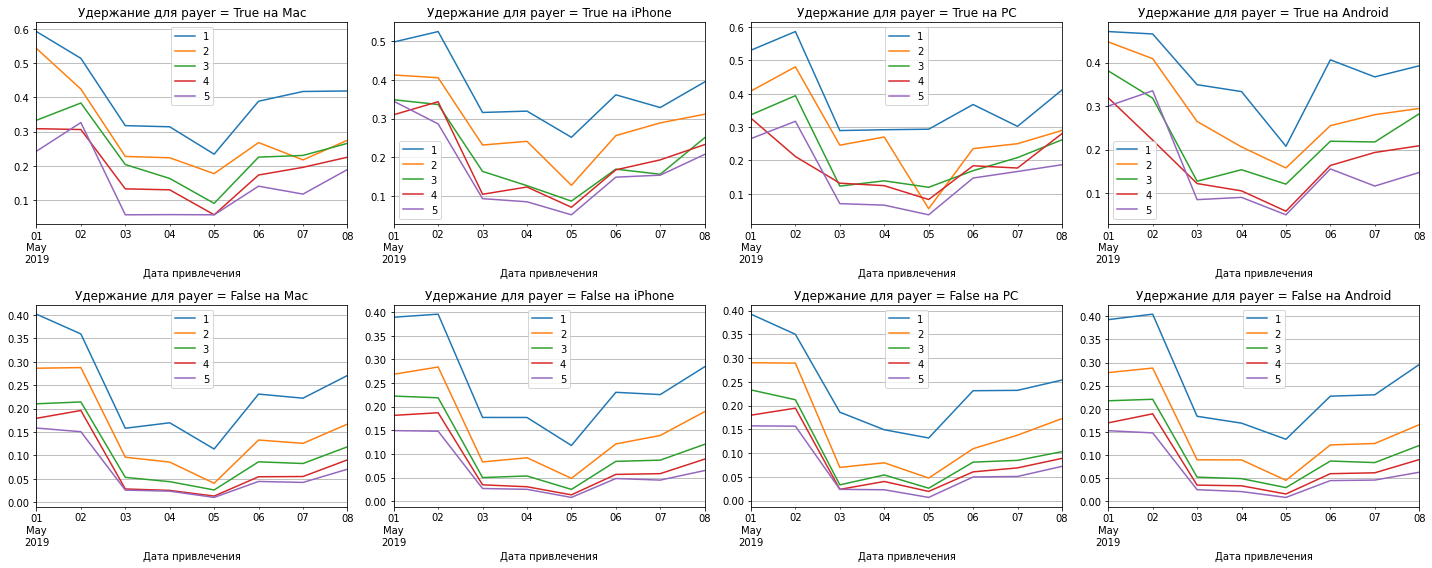

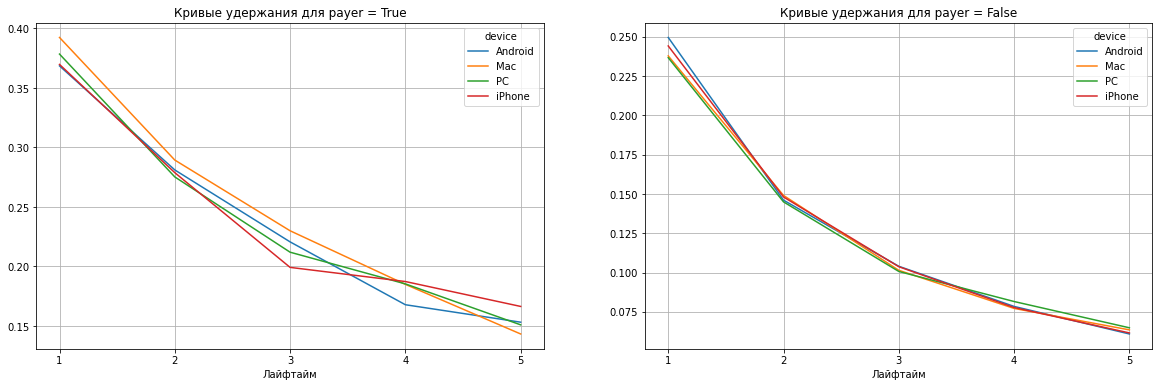

In [25]:
retention_raw, retention, retention_history = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 6, dimensions=['device']
)

# --- строим графики истории изменений ---

plt.figure(figsize=(20, 8))

# берём таблицу динамики удержания retention_history
# исключаем размеры когорт и удержание первого дня
report = retention_history.drop(columns=['cohort_size', 0])

num_rows = len(profiles['payer'].unique())
num_cols = len(profiles['device'].unique())

for i, payer in enumerate(profiles['payer'].unique()):
    for j, device in enumerate(profiles['device'].unique()):
        (
            report.query('payer == @payer and device == @device')
            .droplevel(['payer', 'device'])
            .plot(
                grid=True,
                ax=plt.subplot(num_rows, num_cols, i * num_cols + j + 1),
            )
        )
        plt.xlabel('Дата привлечения')
        plt.title('Удержание для payer = {} на {}'.format(payer, device))
plt.tight_layout()

# --- строим кривые удержания ---

plt.figure(figsize=(20, 6))

# берём таблицу удержания retention
# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()